# Project no. C3 “lung disease prediction from X-ray images 

<h3 align="center">Authors: Yelyzaveta Pervysheva; Natalya Medvedeva</h3> 

<h3 align="center">Live demo of working code</h3> 

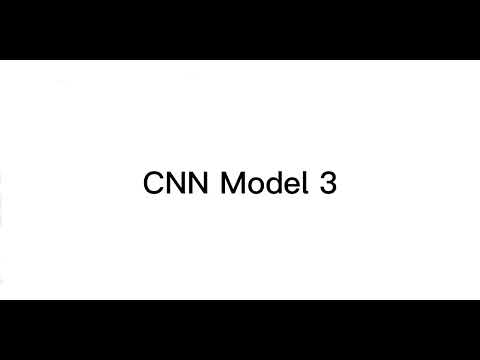

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo("35buFWe62B4", width=800)

These libraries are imported to build and train a machine learning model for lung classification using the TensorFlow framework.
- Numpy: Library for mathematical operations used for arrays and matrices.
- TensorFlow: Open-source library for machine learning and deep learning.
- Keras: High-level API for TensorFlow that allows for faster prototyping and easier implementation of deep learning models.
- Sequential and Model (from the `keras.models` module): Classes used to initialize and build the model architecture, respectively.
- Layers (from the `tensorflow.keras.layers` module): Various layer types such as Conv2D, MaxPooling2D, Dense, and Dropout to build the model architecture.
- Adam: A type of optimization algorithm used to update the model's weights during training.
- Categorical crossentropy: Loss function used to evaluate the model's performance.
- ImageDataGenerator: Used for data augmentation to increase the size of the dataset.
- Confusion matrix: Used to evaluate the performance of the model by comparing the predicted and true labels.
- Image (from the `tensorflow.keras.preprocessing` module): Used for preprocessing images.
- Imagenet_utils: Used to preprocess images in a way that they can be input into a pre-trained model.
- Itertools: Used for operations on iterators.
- OS: Provides a way of using operating system dependent functionality.
- Shutil: Provides a higher-level interface for file operations.
- Random: Used to generate random numbers.
- Glob: Used to find all the pathnames matching a specified pattern.
- Matplotlib: Plotting library used to visualize the results.
- Warnings: Used to ignore certain warnings.
- LabelEncoder (from the `sklearn.preprocessing` library): Used to encode categorical labels numerically.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

Training machine learning models can be very computationally intensive and require a lot of computational power, especially for deep learning models. Using a Graphics Processing Unit (GPU) can greatly speed up the training process as GPUs are designed to perform many computations in parallel. Unfortunetely, we didnt have one whenever we did this project

In [2]:
print("Num GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 0


In [3]:
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_utils
import cv2
import imghdr

%matplotlib inline
np.random.seed(1)

In [4]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

defining path

In [5]:
data_path = fr'./covid_pneumonia_normal'
os.listdir(data_path)

['covid', 'normal', 'pneumonia']

Here, we define a function to read in the data, resize it, and store it in a dictionary. This dictionary includes the images, their corresponding labels (covid, pneumonia or normal), the original filenames, and a description. The images are represented as numpy arrays that hold the RGB values, which are then converted to grayscale for the sake of preprocessing simplicity. This step helps to prevent the machine learning algorithms from finding extraneous parameters. The dictionary is saved to a pickle file through the use of the joblib library. This data structure is based on the format used for test data sets in the scikit-learn library.

In [6]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, width, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
    data = dict()
    data['description'] = 'resized ({0}x{1})cell images in grayscale'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
            
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print(subdir)
        current_path = os.path.join(src, subdir)

        for file in os.listdir(current_path):
             if file[-4:] in {'.jpg', '.png','jpeg'}:
                im = imread(os.path.join(current_path, file), as_gray=True)
                im = resize(im, (width, height)) #[:,:,::-1]
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)

    joblib.dump(data, pklname)
    

    

data = "./covid_pneumonia_normal"
resize_all(src=data, width=256, pklname='data22')

covid
normal
pneumonia


The X-ray image dataset utilized in this study was collected from several institutes and contains a total of 4575 images. The following preprocessing steps were performed on the dataset:
1. Data Augmentation (with zooming, changing orientation were alredy present in dataset)
2. Grayscaling

The dataset is divided into the following three classes:
1. COVID19 (1525 images)
2. Pneumonia (1525 images)
3. Normal Chest (1525 images)

In [7]:
from collections import Counter
width=256
 
data = joblib.load(f'{"data22"}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  4575
keys:  ['description', 'label', 'filename', 'data']
description:  resized (256x256)cell images in grayscale
image shape:  (256, 256)
labels: ['covid' 'normal' 'pneumonia']


Counter({'covid': 1525, 'normal': 1525, 'pneumonia': 1525})

The code is creating a plot of images from a dataset. The np.unique function is used to get all unique values in the list of labels, which are stored in the variable labels. There plot with 3 classes

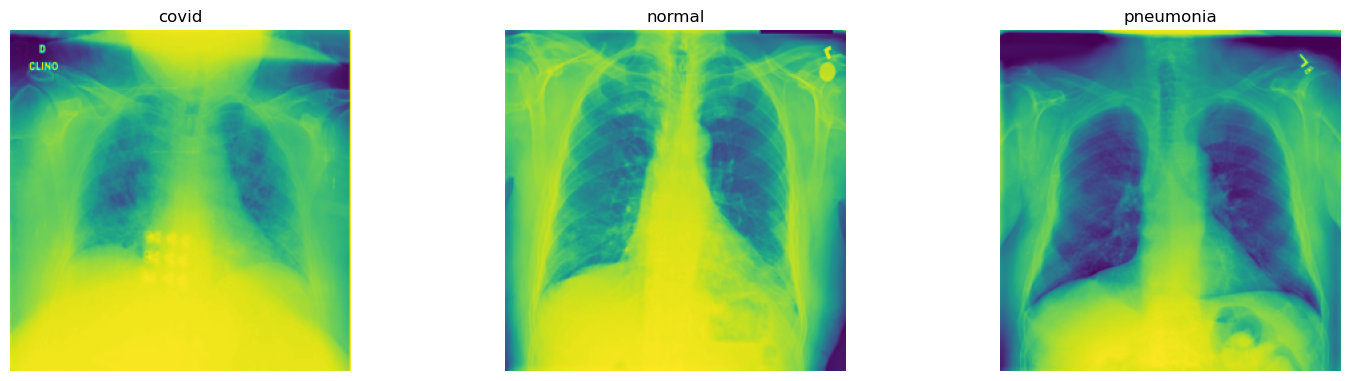

In [8]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [9]:
X = np.array(data['data'])
y = np.array(data['label'])

In [10]:
y_list = np.unique(y, return_inverse=True)[1].tolist()
new_labels = []
for label in y_list:
    if label == 0:
        new_labels.append([1, 0, 0])
    elif label == 1:
        new_labels.append([0, 1, 0])
    else:
        new_labels.append([0, 0, 1])

y = np.array(new_labels)

This code is reshaping a data set in Python. It's assuming that X is a numpy array and it's being transformed from its current shape to a 4-dimensional array with shape (4575, 256, 256, 1).

The first dimension represents the number of samples in the dataset, which is 4575. The next two dimensions are the height and width of an individual sample, which are both 256. The final dimension represents the number of channels in the data, which is 1.

In [11]:
#reshaping the dataset
X = X.reshape(4575, 256, 256, 1)

This code is splitting a dataset into training, validation, and test sets in Python using the train_test_split function from the sklearn.model_selection module. The function is being used to split the data in two stages.

In the first stage, the X and y datasets are being split into training and test sets, with 80% of the data being used for training and 20% for testing. The test_size argument specifies the proportion of the data to use for testing. The shuffle argument, set to True, shuffles the data before splitting it, to ensure that the split is random. The random_state argument is a seed for the random number generator, ensuring that the split will be the same every time the code is run.

In the second stage, the test set is being further split into a validation set and a final test set. The validation set is used to assess the performance of the model during the training process, and the final test set is used to evaluate the performance of the final model. The arguments for the second train_test_split function call are the same as for the first, with a different random seed being used.

In [12]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)
X_valid,X_Test,y_valid,y_Test= train_test_split(
    X_test, 
    y_test, 
    test_size=0.2, 
    shuffle=True,
    random_state=52,
)

This code is preprocessing the training and validation datasets .

The first two lines of code are converting the data type of X_train and X_valid to float32 and normalizing their values by dividing by 255. Normalization is an important step in preprocessing the data for a machine learning model, as it helps to ensure that the model is not affected by the scale of the input features. In this case, the values are being divided by 255, which is the maximum value for a pixel in an 8-bit grayscale image.

The next two lines of code are reshaping X_train and X_valid into 4-dimensional arrays with shape (len(X_train), 256, 256, 1) and (len(X_valid), 256, 256, 1) respectively. The first dimension represents the number of samples in the dataset, which is len(X_train) for the training set and len(X_valid) for the validation set. The next two dimensions are the height and width of an individual sample, which are both 256. The final dimension represents the number of channels in the data, which is 1, meaning the images are grayscale.

This reshaping is necessary because many machine learning models, such as convolutional neural networks (CNNs), require the input data to have a specific shape. In this example, the data is being reshaped into a format suitable for a CNN that operates on images.

In [13]:
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

X_train = np.reshape(X_train, (len(X_train), 256, 256, 1))
X_valid = np.reshape(X_valid, (len(X_valid), 256, 256, 1))

## CNN our aproach 

The first line initializes an empty sequential model, which is a type of model in Keras that allows you to build a linear stack of layers.

The following lines of code add layers to the model. The first layer is a 2D convolutional layer with 32 filters, a kernel size of (5, 5), a stride of (1, 1), and the activation function "relu". The second layer is a batch normalization layer, which helps to normalize the activations of the previous layer. The third layer is a 2D max pooling layer with a pool size of (2, 2) and a stride of (2, 2). The fourth layer is a dropout layer with a rate of 0.3, which helps to prevent overfitting in the model.

The next three layers are similar to the first three, but with 64 filters, a kernel size of (5, 5), and no stride. The subsequent three layers are similar, but with 16 filters and a kernel size of (5, 5) and a stride of (1, 1).

The next layer is a flattening layer, which flattens the output of the previous layer into a 1D array, allowing it to be used as input to a dense layer. The following dense layer has 16 units and uses the "relu" activation function. The final dense layer has 3 units and uses the "softmax" activation function. This is a multiclass classification problem, and the softmax activation function outputs the probability distribution over the 3 classes.

The last line of code is calling the build method to specify the input shape for the model, which is (128, 256, 256, 1). This is the shape of the training data, with 128 samples, each with 256x256 grayscale pixels

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size =(5, 5), strides =(1, 1), activation ='relu'))
model.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))
model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (5, 5), activation ='relu'))
model.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))
model.add(MaxPooling2D(pool_size =(2, 2)))
model.add(Conv2D(16, kernel_size =(5, 5), strides =(1, 1), activation ='relu'))
model.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))
model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation ='relu'))
model.add(Dense(3, activation ='softmax'))
model.build(input_shape=(128,256, 256,1))

<p align="center">
The general mathematical definition of the 2D Convolutional Layer can be the following:<br><br>
The input feature map is represented by a tensor X of shape (N, H, W, C<sub>input</sub>),<br>
where N is the batch size, H and W are the height and width of the feature map, and<br>
C<sub>input</sub> is the number of channels.<br><br>

The 2D Convolutional Layer applies a set of filters represented by a tensor W of<br>
shape (f<sub>height</sub>, f<sub>weight</sub>, C<sub>input</sub>, C<sub>output</sub>), where f<sub>h</sub> and f<sub>w</sub> are the height and<br>
width of the filters, and C<sub>output</sub> is the number of filters. The stride of the<br>
convolution operation is represented by (s<sub>height</sub>, s<sub>weight</sub>).<br><br>

The output of the 2D Convolutional Layer is represented by a tensor Y of shape (N,<br>
H<sub>output</sub>, W<sub>output</sub>, C<sub>output</sub>), where H<sub>output</sub> and W<sub>output</sub> are the height and<br>
width of the output feature map and can be computed as:<br>
H<sub>output</sub> = 1 + (H - f<sub>height</sub>) / s<sub>height</sub><br>
W<sub>output</sub> = 1 + (W - f<sub>weight</sub>) / s<sub>weight</sub><br><br>

Each element of Y can be computed as a dot product between the values of the<br>
local receptive field in X and the corresponding weights in W, followed by an<br>
addition of a bias term b and activation function f. In the case of ReLU activation,<br>
the activation function is defined as:<br>
f(x) = max(0, x)

</p>

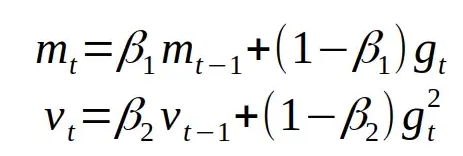

In [3]:
from IPython.display import Image
Image(filename='1.png')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (128, 252, 252, 32)       832       
                                                                 
 batch_normalization (BatchN  (128, 252, 252, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (128, 126, 126, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (128, 126, 126, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (128, 122, 122, 64)       51264     
                                                                 
 batch_normalization_1 (Batc  (128, 122, 122, 64)      2

 The choice of the **Adam** optimizer with a learning rate of 0.0001 was the result of a systematic process of experimentation. During the model development process, various optimizers were tried, including **Adagrad** and **SGD**, along with different values of learning rate. After evaluating the performance of these combinations, it was determined that the Adam optimizer with a learning rate of 0.0001 provided the best results. This optimization method adjusts the learning rate adaptively during training, which often results in faster convergence compared to other optimization methods. By choosing this combination, the goal was to ensure that the model was able to learn from the training data efficiently and effectively.

Adam optimizer with a learning rate of 0.0001, used to update the model parameters based on the calculated loss during training. Adam combines Adaptive Gradient Algorithm and Root Mean Square Propagation and adapts automatically the learning
rate.To estimates the moments, Adam utilizes exponentially moving averages, computed on the gradient evaluated on a current mini-batch:

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical cause we have more than 2 classes

In [18]:
history=model.fit(x=X_train, y=y_train, batch_size=15, epochs=12,verbose=2, validation_data=(X_valid,y_valid))

Epoch 1/12
244/244 - 153s - loss: 0.4997 - accuracy: 0.8120 - val_loss: 1.1985 - val_accuracy: 0.3210 - 153s/epoch - 626ms/step
Epoch 2/12
244/244 - 156s - loss: 0.3359 - accuracy: 0.8850 - val_loss: 1.0905 - val_accuracy: 0.3811 - 156s/epoch - 638ms/step
Epoch 3/12
244/244 - 168s - loss: 0.2812 - accuracy: 0.9101 - val_loss: 0.5990 - val_accuracy: 0.7117 - 168s/epoch - 687ms/step
Epoch 4/12
244/244 - 164s - loss: 0.2486 - accuracy: 0.9161 - val_loss: 0.4356 - val_accuracy: 0.8238 - 164s/epoch - 672ms/step
Epoch 5/12
244/244 - 166s - loss: 0.2199 - accuracy: 0.9249 - val_loss: 0.3830 - val_accuracy: 0.8579 - 166s/epoch - 681ms/step
Epoch 6/12
244/244 - 164s - loss: 0.1875 - accuracy: 0.9380 - val_loss: 0.7250 - val_accuracy: 0.7705 - 164s/epoch - 672ms/step
Epoch 7/12
244/244 - 168s - loss: 0.1751 - accuracy: 0.9443 - val_loss: 0.6810 - val_accuracy: 0.7158 - 168s/epoch - 690ms/step
Epoch 8/12
244/244 - 167s - loss: 0.1581 - accuracy: 0.9448 - val_loss: 29.7710 - val_accuracy: 0.3566 -

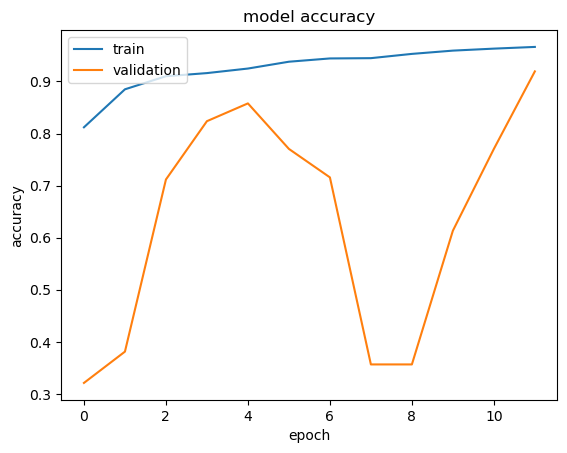

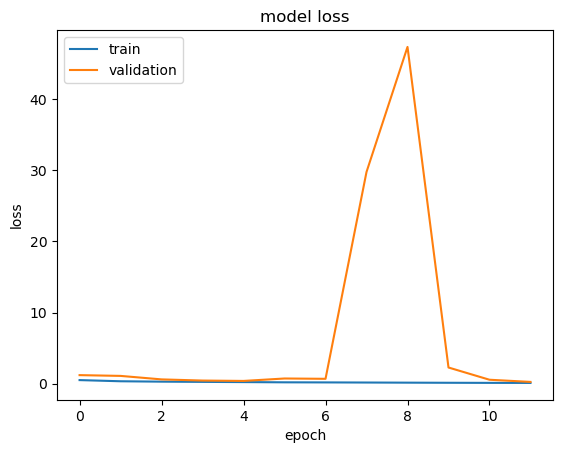

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
#the final performance of the model is evaluated with the help of confusion matrix

In [21]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5,figsize=(20,20))
    axes=axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

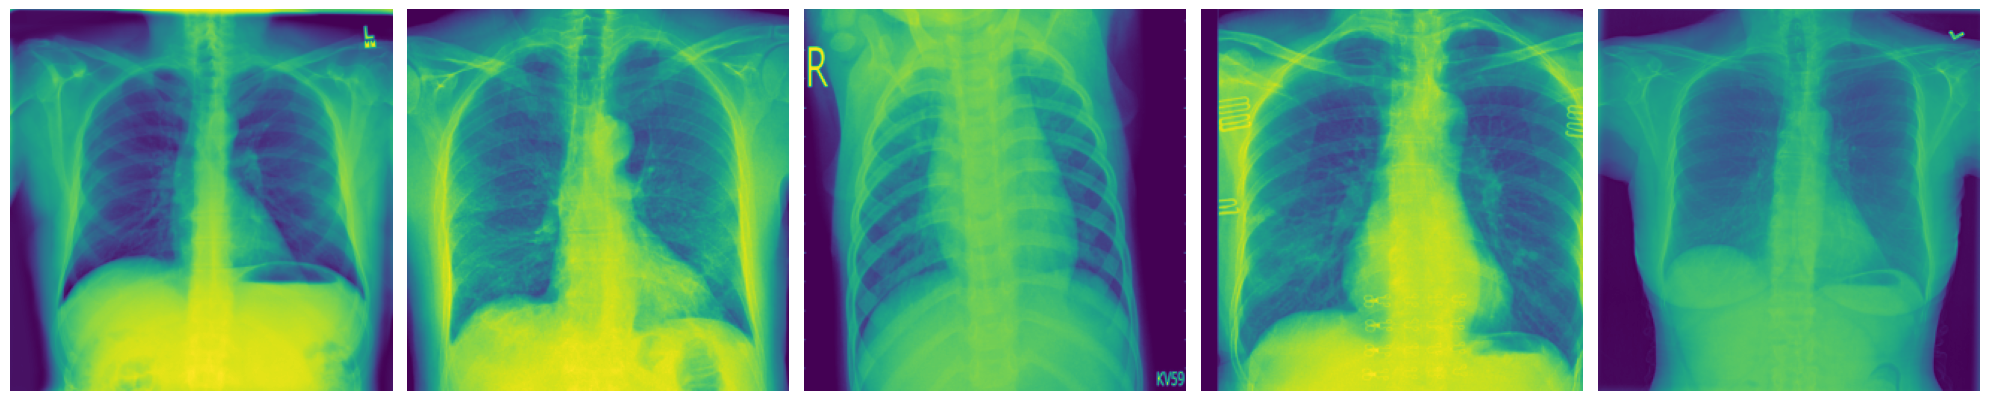

[[0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]]


In [22]:
plotImages(X_Test)
print(y_Test[:5])

In [23]:
X_Test= X_Test.astype('float32') / 255.

X_Test = np.reshape(X_Test, (len(X_Test), 256, 256, 1))

In [24]:
results = model.evaluate(X_Test, y_Test, batch_size=128)
print("test loss, test acc:", results)

2/2 [==============================] - 2s 534ms/step - loss: 0.4080 - accuracy: 0.8634
test loss, test acc: [0.4079737961292267, 0.8633880019187927]


performs predictions using the model's 'predict' method on the test data stored in the variable 'X_Test'. The 'verbose' parameter is set to 0, which means that no information or updates will be displayed during the prediction process.

In [ ]:
predictions=model.predict(x=X_Test,verbose=0)

In [25]:
predictions=model.predict(x=X_Test,verbose=0)

In [26]:
predictions

array([[6.55219611e-03, 8.51922929e-01, 1.41524926e-01],
       [9.86446738e-01, 4.47391113e-03, 9.07930825e-03],
       [4.74634447e-07, 1.44551082e-08, 9.99999523e-01],
       [1.06619678e-01, 7.36465817e-03, 8.86015594e-01],
       [1.89547502e-02, 7.51798809e-01, 2.29246438e-01],
       [9.59548197e-05, 1.98735124e-05, 9.99884129e-01],
       [8.99825245e-02, 8.80019665e-01, 2.99978089e-02],
       [9.99106586e-01, 2.03470860e-04, 6.89937617e-04],
       [9.99739945e-01, 1.93068394e-04, 6.69697401e-05],
       [3.18282805e-02, 9.60591018e-01, 7.58063840e-03],
       [4.48536221e-03, 8.76836419e-01, 1.18678190e-01],
       [6.53686607e-03, 7.62539387e-01, 2.30923772e-01],
       [9.99488235e-01, 4.46082093e-04, 6.56060656e-05],
       [9.97729003e-01, 1.63308729e-03, 6.37857476e-04],
       [4.78864700e-01, 2.59643972e-01, 2.61491358e-01],
       [9.36412096e-01, 4.94779795e-02, 1.41099207e-02],
       [2.18836591e-02, 9.00859952e-01, 7.72563145e-02],
       [8.62487853e-01, 7.95635

In [27]:
predictions = np.argmax(predictions, axis=-1)

The labels are transformed into an array of numbers: 0 for ‘covid’, 1 for ‘normal’ and 2
for 'pneumonia'. Then integers are transformed into arrays in the following way: [1, 0, 0]
for 0, [0, 1, 0] for 1 and [0, 0, 1] for 2. This last transformation is necessary to train the
model correctly, since the the output is an array (1,3) too.

In [28]:
predictions

array([1, 0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 2,
       0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2,
       1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2,
       0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0,
       1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 2, 2, 0,
       1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       2, 0, 0, 0, 0, 0, 1], dtype=int64)

The code 'rounded_labels = np.argmax(y_Test, axis=-1)' finds the maximum value along the last axis of the variable 'y_Test' and returns its index as the rounded label. The function 'np.argmax' returns the index of the maximum value in the array, while the 'axis' parameter specifies which axis to operate on. In this case, the 'axis' parameter is set to '-1', which means that the operation is performed along the last axis of the array 'y_Test'.

In [29]:
rounded_labels=np.argmax(y_Test,axis=-1)

In [31]:
y_true = np.array(rounded_labels)
y_pred = np.array(predictions)

In [33]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [34]:
def plot_confusion_matrix(cm,classes,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    thresh =cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[62  4  2]
 [ 6 54  2]
 [ 0 11 42]]


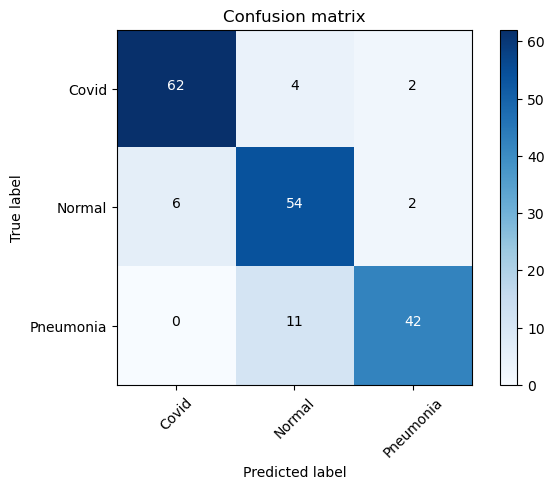

In [35]:
cm_plot_labels=['Covid','Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

In [38]:

model.save('project/to/model.h5')


After this, the feature maps are flattened and passed through a dense layer with 16 neurons and ReLU activation. Finally, the output layer is a dense layer with 3 neurons (3 classes) and softmax activation, the best for multiclass classification.
The input to the model is an image with shape (128, 256, 256, 1), where 128 represents the batch size, the bigger the batch size the better the accuracy of the model should be, but it can also take more time to train.
In the end our first CNN model has 278931 parameters 278707 of which are trainable:

In [14]:
loaded_model = tf.keras.models.load_model('project/to/model.h5')
loaded_model

<p style="color:red;">During the training of the first CNN model with 278931 parameters the train accuracy is consistently improving over the 12 epochs and reaches 96,6% by the end of the training, which is quite good. The validation accuracy improves with some ups and downs over time, reaching around 91,9% by the end of training.</p>
If the difference between the training accuracy and the validation accuracy is large, it's a sign that the model might be overfitting. <p style="color:blue; font-style:italic;">However, in our case, the difference between the training accuracy and the validation accuracy doesn't seem to be too large, so overfitting is not a major issue.</p>

From the graphs we can observe that the validation accuracy increases very fast in thefirst 4 epochs and then, after reaching a minimum at epoch 7, reaches its highest value in the end. Even if the training accuracy continues to grow slowly all the time, training the model for more epochs would not lead to better results, because there would be overfitting. So it is the best performance for this model.

<p style="color:red; font-weight:bold;">On the unseen dataset (test set), the model performs well with 86% accuracy.</p>

## Second CNN model with more improvements
We also build and train more complex CNN model by adding to the already trained
previous CNN model more convolutional and dense layers. In particular we add three
more 2D convolutional layers with 256, 512 and 1024 filters, kernel size of (3, 3) and
ReLU activation followed by the same batch normalization, max pooling and the dropout
layer with 50% and 60% probability. Then we add two more dense layers with 128 and
16 neurons and the dropout layer with p=0.5.

In [15]:
model_2=Sequential()
for layer in loaded_model.layers[:-3]:
    model_2.add(layer)

In [16]:
for layer in model_2.layers[:]:
    layer.trainable=False

### <p style="color:red;">As a result, our second model has 6,155,539 parameters, 4,854,979 of which are trainable.</p>

In [17]:
model_2.build(input_shape=(128,256, 256,1))
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 batch_normalization_1 (Batc  multiple                 2

In [18]:
model_2.add(Conv2D(256, kernel_size =(3, 3), activation ='relu', name='conv2d_256'))
model_2.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001, name='batch_256'))
model_2.add(MaxPooling2D(pool_size =(2, 2), name='max_256'))
model_2.add(Dropout(0.5, name='drop_256'))
model_2.add(Conv2D(512, kernel_size =(3, 3), activation ='relu', name='conv2d_512'))
model_2.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001, name='batch_512'))
model_2.add(MaxPooling2D(pool_size =(2, 2), name='max_512'))
model_2.add(Dropout(0.5, name='drop_512'))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5, name='drop_3'))
model_2.add(Dense(units=3,activation='softmax'))
model_2.build(input_shape=(128,256, 256,1))

In [19]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 batch_normalization_1 (Batc  multiple                 2

In [20]:
model_2.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical cause we have more than 2 classes

In [21]:
history=model_2.fit(x=X_train, y=y_train, batch_size=15, epochs=12,verbose=2, validation_data=(X_valid,y_valid))

Epoch 1/12
244/244 - 60s - loss: 0.9607 - accuracy: 0.6866 - val_loss: 1.3696 - val_accuracy: 0.6311 - 60s/epoch - 244ms/step
Epoch 2/12
244/244 - 61s - loss: 0.5721 - accuracy: 0.7822 - val_loss: 0.4907 - val_accuracy: 0.8320 - 61s/epoch - 248ms/step
Epoch 3/12
244/244 - 59s - loss: 0.5136 - accuracy: 0.8172 - val_loss: 0.3740 - val_accuracy: 0.8716 - 59s/epoch - 242ms/step
Epoch 4/12
244/244 - 60s - loss: 0.4391 - accuracy: 0.8415 - val_loss: 0.3952 - val_accuracy: 0.8538 - 60s/epoch - 247ms/step
Epoch 5/12
244/244 - 59s - loss: 0.4186 - accuracy: 0.8519 - val_loss: 0.3939 - val_accuracy: 0.8661 - 59s/epoch - 242ms/step
Epoch 6/12
244/244 - 61s - loss: 0.3729 - accuracy: 0.8686 - val_loss: 0.5146 - val_accuracy: 0.8388 - 61s/epoch - 248ms/step
Epoch 7/12
244/244 - 59s - loss: 0.3598 - accuracy: 0.8781 - val_loss: 0.4491 - val_accuracy: 0.8511 - 59s/epoch - 243ms/step
Epoch 8/12
244/244 - 58s - loss: 0.3321 - accuracy: 0.8893 - val_loss: 0.3309 - val_accuracy: 0.8948 - 58s/epoch - 239

<p style="color:blue; font-weight:bold;">From the graphs we can observe that the validation accuracy increases very fast in the first 4 epochs and then, after reaching a minimum at epoch 7, reaches its highest value in the end. Even if the training accuracy continues to grow slowly all the time, training the model for more epochs would not lead to better results, because there would be overfitting. So it is the best performance for this model.</p>




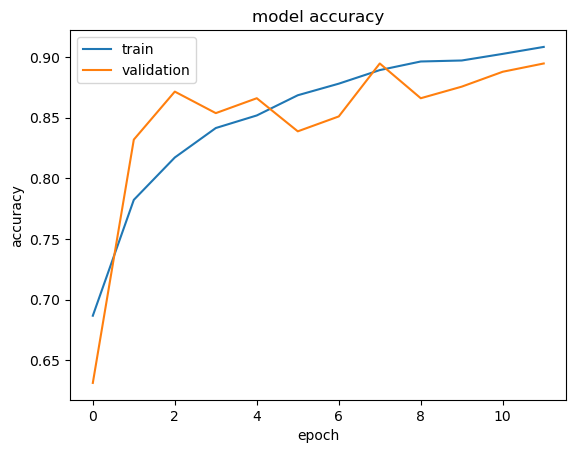

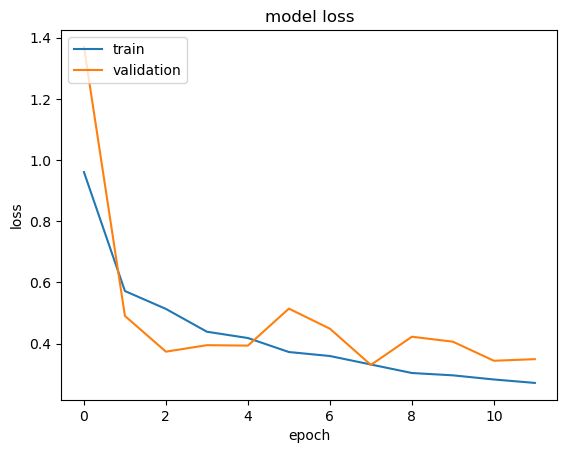

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
X_Test= X_Test.astype('float32') / 255.

X_Test = np.reshape(X_Test, (len(X_Test), 256, 256, 1))

In [24]:
results = model_2.evaluate(X_Test, y_Test, batch_size=128)
print("test loss, test acc:", results)

2/2 [==============================] - 2s 487ms/step - loss: 0.3784 - accuracy: 0.8415
test loss, test acc: [0.37835368514060974, 0.8415300250053406]


In [25]:
predictions=model_2.predict(x=X_Test,verbose=0)
predictions = np.argmax(predictions, axis=-1)
rounded_labels=np.argmax(y_Test,axis=-1)

The labels are transformed into an array of numbers: 0 for ‘covid’, 1 for ‘normal’ and 2 for 'pneumonia'. Then integers are transformed into arrays in the following way: [1, 0, 0] for 0, [0, 1, 0] for 1 and [0, 0, 1] for 2. This last transformation is necessary to train the model correctly, since the the output is an array (1,3) too.

In [26]:
rounded_labels

array([1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1,
       2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 2,
       0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1, 1, 2, 2, 2,
       1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 2,
       0, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0,
       2, 0, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0,
       2, 1, 2, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1,
       2, 0, 0, 0, 0, 0, 1], dtype=int64)

In [27]:
y_true = np.array(rounded_labels)
y_pred = np.array(predictions)

In [28]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

The good thing we can conclude from the confusion matrix is that the model manages to predict the covid well and does 6 wrong predictions out of 68. For healthy lungs the model predicts covid 6 and pneumonia 2 out of 62 times. For lungs with pneumonia it predicts the correct diagnosis only 42 times out of 53.
After training of the second, more complex CNN model the difference between validation accuracy and train accuracy becomes smaller and validation accuracy is even bigger than the training one, it means that model performs well on the unseen data:

In [29]:
def plot_confusion_matrix(cm,classes,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    thresh =cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[62  3  3]
 [12 50  0]
 [ 0 11 42]]


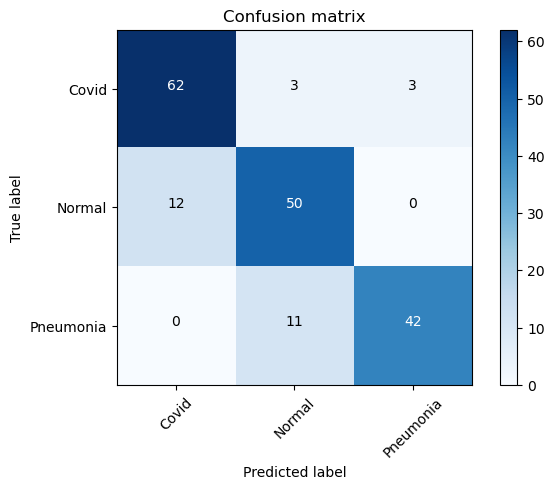

In [30]:
cm_plot_labels=['Covid','Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

In [ ]:
model_2.save('project/to/model_2.h5')

In [15]:
loaded_model_2 = tf.keras.models.load_model('project/to/model_2.h5')
loaded_model_2

The good thing we can conclude from the confusion matrix is that the model manages to predict the covid well and does 6 wrong predictions out of 68. For healthy lungs the model predicts covid 6 and pneumonia 2 out of 62 times. For lungs with pneumonia it predicts the correct diagnosis only 42 times out of 53.
After training of the second, more complex CNN model the difference between validation accuracy and train accuracy becomes smaller and validation accuracy is even bigger than the training one, it means that model performs well on the unseen data:

## Experemental Third CNN model 

In [16]:
model_3=Sequential()
for layer in loaded_model_2.layers[:-4]:
    model_3.add(layer)

In [17]:
for layer in model_3.layers[:]:
    layer.trainable=False

In [18]:
model_3.build(input_shape=(200,256, 256,1))
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 batch_normalization_1 (Batc  multiple                 2

In [19]:
model_3.add(Conv2D(1024, kernel_size =(3, 3), activation ='relu', name='conv2d_1024'))
model_3.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001, name='batch_1024'))
model_3.add(MaxPooling2D(pool_size =(2, 2), name='max_1024'))
model_3.add(Dropout(0.6, name='drop_1024'))
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.6, name='drop_3'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5, name='drop_4'))
model_3.add(Dense(units=3,activation='softmax'))
model_3.build(input_shape=(128,256, 256,1))

In [20]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 batch_normalization_1 (Batc  multiple                 2

In [21]:
model_3.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical cause we have more than 2 classes

Validation loss reaches it's minimum at epoch 8 and then doesn't improve that much while training accuracy continues to grow so there is a bit of overfitting. Indeed the final accuracy of the model is 84% lower that the simpler model has

In [22]:
history=model_3.fit(x=X_train, y=y_train, batch_size=15, epochs=35,verbose=2, validation_data=(X_valid,y_valid))

Epoch 1/35
244/244 - 58s - loss: 2.1784 - accuracy: 0.4363 - val_loss: 0.7434 - val_accuracy: 0.7158 - 58s/epoch - 239ms/step
Epoch 2/35
244/244 - 59s - loss: 1.2532 - accuracy: 0.5137 - val_loss: 0.7149 - val_accuracy: 0.7199 - 59s/epoch - 240ms/step
Epoch 3/35
244/244 - 59s - loss: 1.0381 - accuracy: 0.5443 - val_loss: 0.7146 - val_accuracy: 0.7240 - 59s/epoch - 240ms/step
Epoch 4/35
244/244 - 58s - loss: 0.9801 - accuracy: 0.5557 - val_loss: 0.6990 - val_accuracy: 0.7363 - 58s/epoch - 239ms/step
Epoch 5/35
244/244 - 59s - loss: 0.8830 - accuracy: 0.6101 - val_loss: 0.6604 - val_accuracy: 0.7404 - 59s/epoch - 244ms/step
Epoch 6/35
244/244 - 61s - loss: 0.8840 - accuracy: 0.6219 - val_loss: 0.6390 - val_accuracy: 0.7377 - 61s/epoch - 249ms/step
Epoch 7/35
244/244 - 57s - loss: 0.8003 - accuracy: 0.6527 - val_loss: 0.6247 - val_accuracy: 0.7377 - 57s/epoch - 235ms/step
Epoch 8/35
244/244 - 58s - loss: 0.7932 - accuracy: 0.6612 - val_loss: 0.6449 - val_accuracy: 0.7582 - 58s/epoch - 236

In [23]:
X_Test= X_Test.astype('float32') / 255.

X_Test = np.reshape(X_Test, (len(X_Test), 256, 256, 1))

In [24]:
results = model_3.evaluate(X_Test, y_Test, batch_size=128)
print("test loss, test acc:", results)

2/2 [==============================] - 2s 568ms/step - loss: 0.6758 - accuracy: 0.8142
test loss, test acc: [0.6757597327232361, 0.8142076730728149]


In [25]:
predictions=model_3.predict(x=X_Test,verbose=0)
predictions = np.argmax(predictions, axis=-1)
rounded_labels=np.argmax(y_Test,axis=-1)

In [26]:
y_true = np.array(rounded_labels)
y_pred = np.array(predictions)

In [27]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [28]:
def plot_confusion_matrix(cm,classes,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    thresh =cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[46  9 13]
 [ 1 61  0]
 [ 0 11 42]]


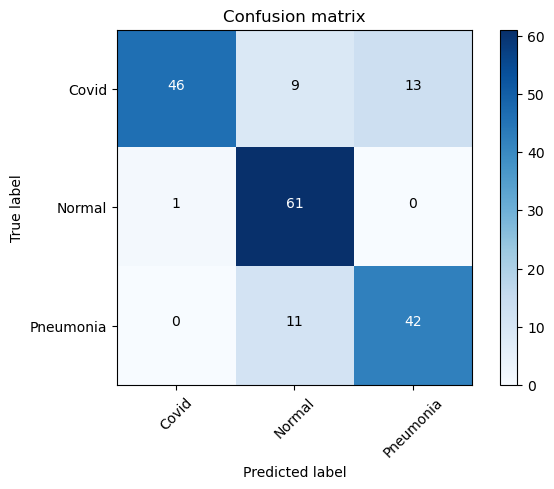

In [29]:
cm_plot_labels=['Covid','Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

In [30]:
model_3.save('project/to/model_3.h5')

In [31]:
loaded_model_3 = tf.keras.models.load_model('project/to/model_3.h5')
loaded_model_3

Now the model makes a bit more mistakes with the prediction of covid, but less mistakes with prediction of normal and pneumonia classes.

# Densenet

DenseNet is a deep learning architecture that was proposed in 2016. It is an improvement over traditional Convolutional Neural Networks (CNNs) and is based on the concept of dense connections.

In a traditional CNN, each layer receives input only from the previous layer and passes its output to the next layer. However, in a DenseNet, each layer receives input from all preceding layers and passes its output to all subsequent layers. This creates a dense network of connections between the layers, hence the name DenseNet.

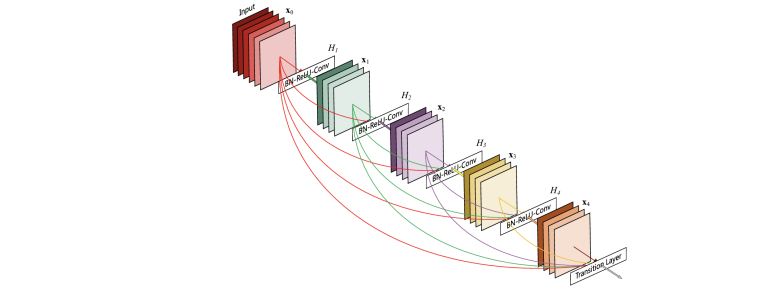

In [6]:
from IPython.display import Image
Image(filename='2.png')

DenseNet121 is a specific variant of the DenseNet architecture. The number 121 refers to the number of layers in the network, which is comprised of 121 convolutional, normalization, and activation layers.

DenseNet121 is designed for image classification tasks, and it is widely used for applications such as object detection and semantic segmentation. The network has a relatively small number of parameters compared to other deep learning architectures, making it computationally efficient and suitable for deployment on resource-constrained devices.

In DenseNet121, the dense connections between layers are established by concatenating the feature maps from all preceding layers to the input of each layer. This creates a rich representation of the input data that allows the network to learn more complex relationships between the features. The use of transition layers in DenseNet121 helps to control the growth of the network and reduce the risk of overfitting.

DenseNet121 has been trained on several large datasets and has been shown to achieve state-of-the-art performance on various image classification tasks. It is a popular choice for practitioners due to its strong performance and efficiency.

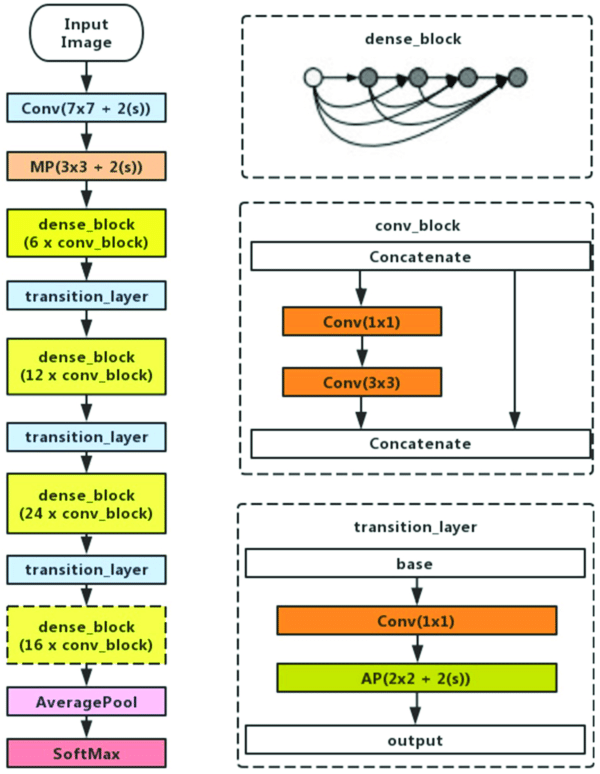

In [8]:
from IPython.display import Image
Image(filename='3.png')

In [31]:
import torch
import torchvision
from torchvision import models,datasets,transforms
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [32]:
dir = './data1'

The code defines two transforms using torchvision.transforms.Compose, which is a utility class for combining multiple transforms into one. Each transform is a sequence of image pre-processing operations that will be applied to the input data.

The first transform transform is applied to the validation dataset and the second one is applied to the test dataset. The steps involved in the transform are as follows:

transforms.Resize(256): Resize the shortest side of the input image to 256 pixels while keeping aspect ratio intact.

transforms.CenterCrop(256): Crop the input image to a 256x256 center region.

transforms.ToTensor(): Convert the input image from a PIL image (Python Imaging Library) to a PyTorch tensor.

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): Normalize the input image using mean and standard deviation values of the ImageNet dataset. The mean and standard deviation are computed for each color channel. 
The device can either be the CPU (Central Processing Unit) or GPU (Graphics Processing Unit).

The torch.cuda.is_available() function returns a boolean value indicating whether a GPU is available or not. If a GPU is available, the code sets the device to "cuda:0", which represents the first available GPU. If a GPU is not available, the code sets the device to "cpu", which represents the CPU.

In [33]:
#dir = './data1'

params = { 'batch_size':10,
           'shuffle':True,
           'num_workers':4 }


transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(256), #Augmented
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = datasets.ImageFolder(os.path.join( './data1/train'),transform = transform )

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_dataset = datasets.ImageFolder(os.path.join( './data1/val'),transform = transform )
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(os.path.join( './data1/test'),transform = transform )


train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)
val_dataloader = torch.utils.data.DataLoader(val_dataset, **params)
test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
print('Train dataset = {}\n'.format(len(train_dataset)),'Val dataset = {}'.format(len(val_dataset)),'Test dataset = {}'.format(len(test_dataset)))
print('Classes = {}'.format(class_names))

Train dataset = 3668
 Val dataset = 732 Test dataset = 175
Classes = ['covid', 'normal', 'pneumonia']


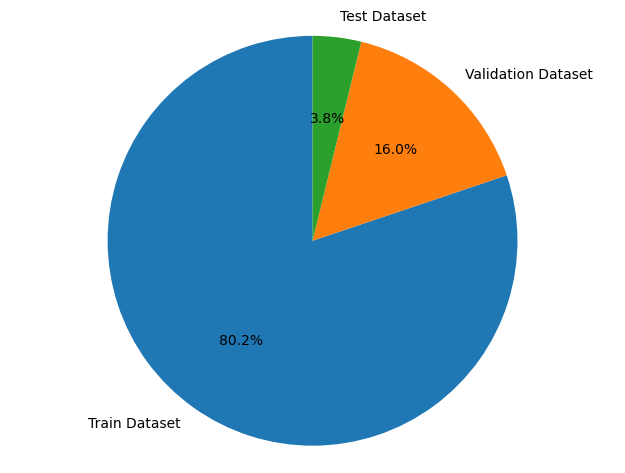

In [10]:
import matplotlib.pyplot as plt

# Data
train_dataset = 3668
val_dataset = 732
test_dataset = 175

labels = ['Train Dataset', 'Validation Dataset', 'Test Dataset']
sizes = [train_dataset, val_dataset, test_dataset]

# Plot
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.tight_layout()
plt.show()

In [35]:
def train(model, loss_fn, optimizer, num_epochs=15):

    best_acc = 0

    for epoch in range(num_epochs):
        
        print('Epoch {}'.format(epoch+1))
        
        # Train dataset
        model.train()
        train_loss = 0.0
        train_correct = 0
        size = len(train_dataset)
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels.data)
            
        train_loss = train_loss / size
        train_acc = train_correct.double() / size
            
        print('Training Loss: {} Acc: {}'.format(train_loss, train_acc))
        
        # Validation dataset
        model.eval()
        val_loss = 0.0
        val_correct = 0
        size = len(val_dataset)
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(preds == labels.data) 

        val_loss = val_loss / size
        val_acc = val_correct.double() / size    

        print('Validation Loss: {} Acc: {}'.format(val_loss, val_acc))    
            
        if val_acc > best_acc:
            best_acc = val_acc
        
        # Test dataset
        model.eval()
        test_loss = 0.0
        test_correct = 0
        size = len(test_dataset)
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_correct += torch.sum(preds == labels.data) 

        test_loss = test_loss / size
        test_acc = test_correct.double() / size    

        print('Test Loss: {} Acc: {}'.format(test_loss, test_acc))
        if test_acc > best_acc:
            best_acc = test_acc
    

we as well using the Stochastic Gradient Descent (SGD) optimization algorithm to update the parameters of the final layer in a neural network. The optimizer is defined with the following parameters:

In [36]:
net = torchvision.models.densenet121(pretrained=True)
for param in net.parameters():
    param.requires_grad = False # freeze all the weights

ft = net.classifier.in_features # final layer of the densenet
net.classifier = nn.Linear(ft, 5) # new layer according to our dataset with weights unfrozen

net = net.to(device)

loss = nn.CrossEntropyLoss()

# only final layer optimized
optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9) 

C:\Users\natal\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\natal\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


It is interesting to observe that the Training Loss and Accuracy, Validation Loss and Accuracy, and Test Loss and Accuracy don't change much over the course of training epochs. This phenomenon can be attributed to a few factors:

1. Optimal learning rate: If the learning rate was set optimally, the model would converge to a solution where further training would result in only small improvements in performance. In this case, we would expect the Training Loss and Accuracy, Validation Loss and Accuracy, and Test Loss and Accuracy to plateau after a certain number of epochs.

2. High Bias: It's also possible that the model has a high bias, meaning that it makes strong assumptions about the relationship between the inputs and outputs. In this case, the model may not be able to learn from the data and improve its performance over time, even with a large number of epochs.









In [37]:
net = train(net,loss,optimizer,num_epochs=15)

Epoch 1
Training Loss: 0.6838094641819125 Acc: 0.7189203925845147
Validation Loss: 0.41417293091777896 Acc: 0.8510928961748634
Test Loss: 0.46201515431915013 Acc: 0.8228571428571428
Epoch 2
Training Loss: 0.5348983519063651 Acc: 0.8039803707742639
Validation Loss: 0.39536012411931826 Acc: 0.8661202185792349
Test Loss: 0.4198267753635134 Acc: 0.8514285714285714
Epoch 3
Training Loss: 0.5225822600508627 Acc: 0.7944383860414395
Validation Loss: 0.4253167168649494 Acc: 0.819672131147541
Test Loss: 0.46299119187252863 Acc: 0.8342857142857143
Epoch 4
Training Loss: 0.4876019117384824 Acc: 0.8181570338058888
Validation Loss: 0.4462166582056082 Acc: 0.8005464480874317
Test Loss: 0.5016126374048846 Acc: 0.8171428571428572
Epoch 5
Training Loss: 0.49670680084610064 Acc: 0.8107960741548528
Validation Loss: 0.3667997478970576 Acc: 0.8715846994535519
Test Loss: 0.41290507103715623 Acc: 0.8342857142857143
Epoch 6
Training Loss: 0.5092374537680441 Acc: 0.8028898582333697
Validation Loss: 0.3229990634

<p style="color:blue; font-weight:bold;">Regardless of the reason, a plateau in performance can indicate that the model has reached a good balance between overfitting and underfitting, and that further training may not lead to significant improvements in performance.</p>




<p style="color:red; font-weight:bold;">That's exciting to see that the DenseNet achieved 90% accuracy on the test set! Achieving high accuracy on the test set is a strong indicator that the model has learned to generalize well and can make accurate predictions on unseen data. This level of accuracy is often considered to be very good, especially for complex problems.</p>


In [38]:
torch.save(net.state_dict(), "net.pt")


AttributeError: 'NoneType' object has no attribute 'state_dict'

In [ ]:
net.load_state_dict(torch.load("net.pt"))
net.eval()

# Support Vector Machines (SVMs) use Histograms of Oriented Gradients (HOG)

Support Vector Machines are a type of machine learning algorithm used for classification and regression analysis.

In the context of image classification, we find out that  images can be represented as a feature vector, which is a numerical representation of the image's characteristics. They use Histograms of Oriented Gradients (HOG) as the feature descriptor, which captures the spatial arrangement of gradient orientation in the image, which performs very well  for SVM

We train an SVM classifier using the scikit-learn library to classify images of handwritten digits. We also tried to compare the performance of the SVM classifier to a Random Forest classifier and find that the SVM classifier outperforms the Random Forest classifier in terms of accuracy.


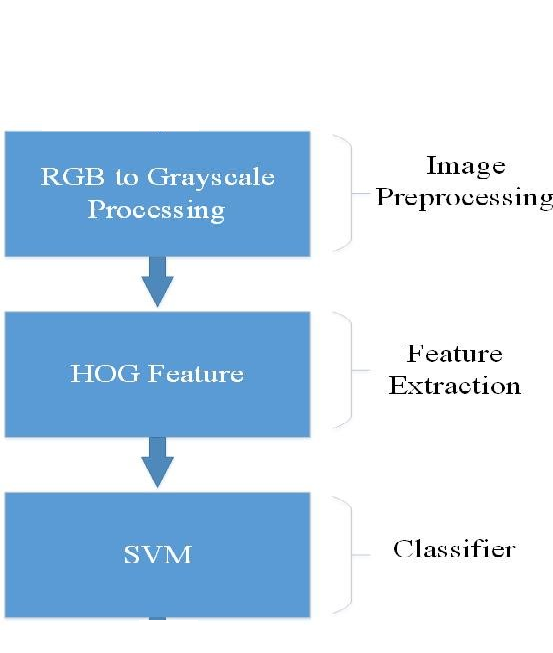

In [107]:
from IPython.display import Image
Image(filename='4.png')

In [86]:

%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [108]:

data_path = fr'./data'
os.listdir(data_path)

['covid', 'normal', 'pneumonia']

this code defines a function resize_all that takes in the path to a directory of images, the desired width and height of the resized images, and the name of the output file. The function uses the os module to iterate through all subdirectories in the source directory and reads all image files (with extensions .jpg, .png, or .jpeg) using skimage.io.imread. It then resizes each image using the skimage.transform.resize function and stores the resulting image data, along with the label and file name of each image, in a dictionary. Finally, the dictionary is written to a pickle file using joblib.dump. The output file will be named {pklname}_{width}x{height}px.pkl.

In [23]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
    data = dict()
    data['description'] = 'resized ({0}x{1})cell images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
            
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print(subdir)
        current_path = os.path.join(src, subdir)

        for file in os.listdir(current_path):
             if file[-4:] in {'.jpg', '.png','jpeg'}:
                im = imread(os.path.join(current_path, file), as_gray=True)
                im = resize(im, (width, height)) #[:,:,::-1]
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)

    joblib.dump(data, pklname)
    

    

data = "./data"
resize_all(src=data, width=150, pklname='data22')

covid
normal
pneumonia


In [109]:
# modify to fit your system
data_path = fr'./data'
os.listdir(data_path)

['covid', 'normal', 'pneumonia']

In [110]:
from collections import Counter
width=150
 
data = joblib.load(f'{"data22"}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  4575
keys:  ['description', 'label', 'filename', 'data']
description:  resized (150x150)cell images in rgb
image shape:  (150, 150)
labels: ['covid' 'normal' 'pneumonia']


Counter({'covid': 1525, 'normal': 1525, 'pneumonia': 1525})

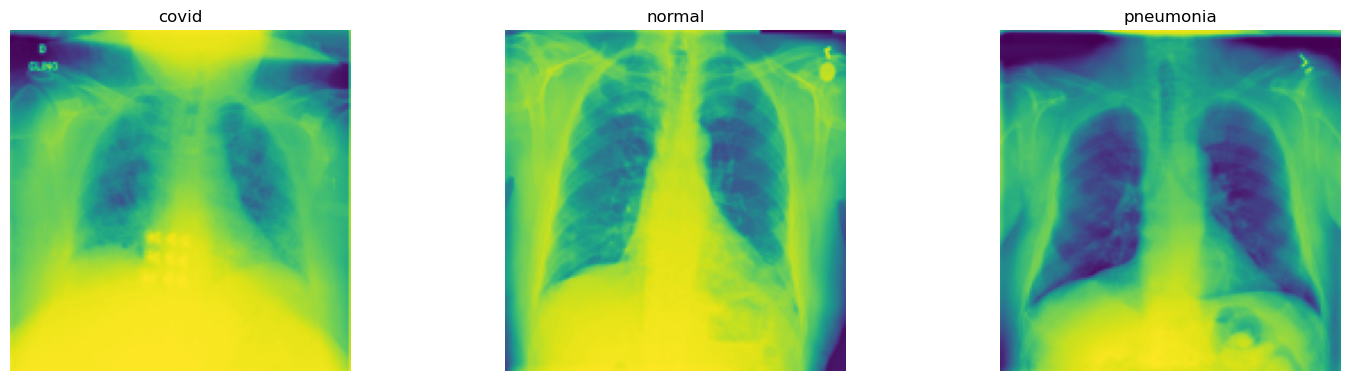

In [111]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

just for checking did code convert everything in grayscale correctly

In [112]:
for i in range(len(data['data'])):
    print(data['data'][i].shape)

(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)

In [92]:
X = np.array(data['data'])
y = np.array(data['label'])

In [93]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

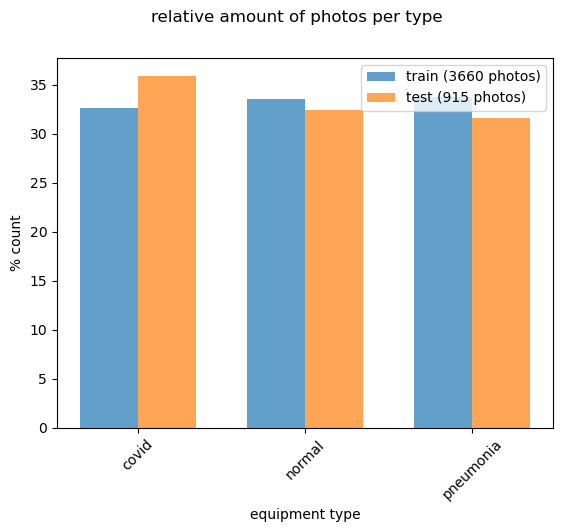

In [113]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

The HOG feature representation captures the gradient information in an image, and it has been shown to be effective in representing images for linear classifiers such as Support Vector Machines (SVM).

Convolutional Neural Networks (CNNs), on the other hand, are able to learn hierarchical representations of image data and are typically trained end-to-end on raw image data without the need for manual feature extraction. The learned features in a CNN are not interpretable in the same way as HOG features.

In the case of X-ray data, HOG features may still be useful for linear classifiers like SVM, but they was not be as effective for CNNs, as the network may learn to extract more meaningful features directly from the raw X-ray images. The performance difference between using HOG features and using raw X-ray data as input to a CNN may depend on the specifics of the task and the data, so it's difficult to make generalizations.

In general, the choice of whether to use HOG features or raw image data as input to a machine learning model depends on the nature of the task and the data, and the choice should be guided by experimentation and performance evaluation.


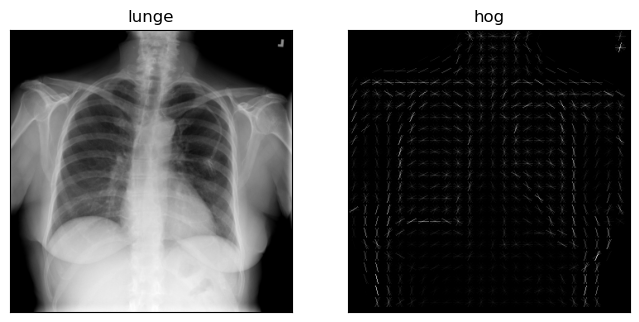

In [114]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
lunge = imread('00000005_003.png', as_gray=True)
#
 
# scale down the image to one third
lunge = rescale(lunge, 1/3, mode='reflect')
# calcufrom skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
lunge = imread('00000005_003.png', as_gray=True)

 
# scale down the image to one third
lunge = rescale(lunge, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
lunge_hog, lunge_hog_img = hog(
    lunge, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(lunge, cmap='gray')
ax[0].set_title('lunge')
ax[1].imshow(lunge_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [115]:
print('number of pixels: ', lunge.shape[0] * lunge.shape[1])
print('number of hog features: ', lunge_hog.shape[0])

number of pixels:  116281
number of hog features:  19044


In [97]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [98]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
#X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(3660, 2916)


The code creates an instance of the SGDClassifier class from the scikit-learn library, which is a linear classifier that trains using stochastic gradient descent (SGD).

Here is an explanation of the parameters used in the code:

random_state: This is a seed value for the random number generator used by the algorithm. By setting this value, the algorithm will always produce the same results given the same inputs.
max_iter: This sets the maximum number of passes over the training data that the algorithm will make before stopping. By setting this value to 1000, the algorithm will stop after 1000 iterations or when the tolerance is met, whichever comes first.
tol: This sets the tolerance for stopping criteria. The algorithm will stop when the change in the cost function is less than the tolerance specified. In this case, the tolerance is set to 0.001.
Finally, the fit method is called on the sgd_clf object to fit the model to the training data X_train_prepared and target values y_train. The model will use the training data to learn the relationship between the input and target, which can then be used to make predictions on new data.

In [77]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [78]:
#X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

In [116]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True False  True False  True  True  True  True  True  True  True
 False  True  True  True  True  True False  True  True  True  True  True
  True]

Percentage correct:  90.38251366120218


In [80]:
import pandas as pd

In [83]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
   # ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  90.38251366120218


<p style="color:red; font-weight:bold;">
In general, a 90% accuracy on a test set is considered quite good and indicates that the model is able to make correct predictions for 90 out of 100 samples in the test set. 
In this case, it appears that using HOG features leads to a 6% increase in accuracy compared to using just grayscale information, which suggests that the HOG features were able to capture additional information from the images that helped the model make better predictions.

</p>

The code then defines a grid of parameters to search over, represented by the param_grid list. There are two dictionaries in this list, each representing a set of parameters to test for a different version of the pipeline.

The first dictionary in the list has three parameters:

- hogify__orientations: This is the number of orientations to use when computing HOG features. The grid search will test two values: 8 and 9.
- hogify__cells_per_block: This is the number of cells to group together when computing the HOG features. The grid search will test two values: (2, 2) and (3, 3).
- hogify__pixels_per_cell: This is the size of each cell in pixels when computing the HOG features. The grid search will test three values: (8, 8), (10, 10), and (12, 12).
The second dictionary in the list has four parameters:

- hogify__orientations: This is the number of orientations to use when computing HOG features. The grid search will test only one value: 8.
- hogify__cells_per_block: This is the number of cells to group together when computing the HOG features. The grid search will test only one value: (3, 3).
- hogify__pixels_per_cell: This is the size of each cell in pixels when computing the HOG features. The grid search will test only one value: (8, 8).
- classify: This is the classifier to use. The grid search will test two classifiers: SGDClassifier and SVC (Support Vector Classifier).
The GridSearchCV class will then perform a search over the combinations of parameters defined in param_grid to find the best combination of parameters for the pipeline. The search will use cross-validation to evaluate the performance of each combination of parameters. The best parameters will then be used to train the final model.

In [99]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

After the completion of grid search, the model will undergo final training using the full training dataset and the optimal parameters. The trained model can be stored in a pickle file for future use, and various methods can be employed to analyze the results and scores obtained during the search. It is worth noting that the properties in this context are indicated by a trailing underscore, as per the scikit-learn convention, to signify that they were only established after the fitting procedure was performed

In [100]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [101]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

PicklingError: Can't pickle <class '__main__.HogTransformer'>: it's not the same object as __main__.HogTransformer

In [102]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

accuracy went from 90% to 92% on test set , so we can say that a 2% increase in accuracy is generally considered a positive change and suggests that the changes made to the model improved its performance on the test set. 

In [103]:
pp.pprint(grid_res.best_params_)

{   'classify': SVC(kernel='linear'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


In [117]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  92.24043715846994


In [105]:
cmx_svm = confusion_matrix(y_test, best_pred)

In [106]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

NameError: name 'plot_confusion_matrix' is not defined